# Model for single mode squeezed vacuum and squeezed coherent state

We test the boson sampling operator (no training) 
on coherent states and squeezed states

We compare with theory

Version with transformlayer

nonlinearxwaves@gmail.com<br>
@version 30 January 2021<br>
@version 1 october 2023<br>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # disable warning messages 

In [2]:
import numpy as np
from thqml import phasespace as ps
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
tf_complex = tf.complex
tf_real = tf.float32
np_complex = complex
np_real = np.float64

In [4]:
tf.keras.backend.clear_session()

In [5]:
np.set_printoptions(precision=2)

Check GPU

In [6]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


## Dimension

In [7]:
N = 4

In [8]:
n=np.floor_divide(N,2)

## Build vacuum by the Gaussian state

In [9]:
vacuum = ps.VacuumLayer(N)

## Squeezer for mode 0

In [10]:
r_np=0.8;
theta_np=np.pi/4;
squeezer=ps.SingleModeSqueezerLayer(N, r_np=r_np, theta_np=theta_np, n_squeezed=0)

## Displacer for mode 1

Define the alpha vector for the alpha

In [11]:
alpha=np.zeros([2],dtype=np_complex)

In [12]:
alpha[0]=0
alpha[1]=1.5
print(alpha)
print(np.abs(alpha)**2)

[0. +0.j 1.5+0.j]
[0.   2.25]


Define the corresponding displacement vector

In [13]:
dinput_np=np.zeros([N,1], dtype=np_real)
for j in range(n):
    dinput_np[2*j]=np.sqrt(2)*np.real(alpha[j])
    dinput_np[2*j+1]=np.sqrt(2)*np.imag(alpha[j])

In [14]:
dinput = tf.constant( dinput_np, dtype=vacuum.dtype)
displacer = ps.DisplacementLayerConstant(dinput)

## Build the model

In [15]:
xin = tf.keras.layers.Input(N)
x1, a1 = displacer(xin)
x2, a2 = squeezer(x1, a1)
chir, chii = vacuum(x2, a2)
model = tf.keras.Model(inputs = xin, outputs=[chir, chii])

# Evaluate the Qtransform with the transform layer

In [16]:
kin = tf.keras.layers.Input([N])
QL = ps.QTransformLayer(N,model)
Q=QL(kin)
Qrho = tf.keras.Model(inputs =  kin, outputs=[Q])

In [17]:
Qrho.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 4)]               0         
                                                                 
 q_transform_layer (QTransfo  (None, None)             22        
 rmLayer)                                                        
                                                                 
Total params: 22
Trainable params: 2
Non-trainable params: 20
_________________________________________________________________


# Test the Pr operator 

Probability of zero photon

In [18]:
%%time
ps.Pr([0,0], Qrho)

CPU times: user 15.8 ms, sys: 0 ns, total: 15.8 ms
Wall time: 14.8 ms


<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.08]], dtype=float32)>

Probability of two photons

In [19]:
%%time
ps.Pr([0,2], Qrho)

CPU times: user 121 ms, sys: 2.95 ms, total: 124 ms
Wall time: 123 ms


<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.2], dtype=float32)>

## Define a function with the expected theoretical value

In [20]:
def Psqueeze(n, r):
    # returh the theory value for the Boson sampling for coherent states
    
    scale = 1.0
    if n % 2 ==0 :
        scale = scale/np.cosh(r)
        scale = scale*np.power(np.tanh(r), n)
        scale = scale*np.math.factorial(n)
        scale = scale/np.power(2.0,n)
        n2 = n//2 # floor divide
        scale = scale/np.power(np.math.factorial(n2),2)
    else:
        scale = 0.0
    
    return scale 

def Pcoherent(nj, alpha):
    # returh the theory value for photon distribution in a coherent state
    
    scale = 1

    aj2 = np.abs(alpha)**2
    scale = scale/np.math.factorial(nj)
    scale = scale*np.exp(-aj2)*np.power(aj2,nj)
    
    return scale 

def theoryPr(nbar, alpha):
    # returh the theory value for the Boson sampling for 
    # one coherent state (mode 1) and one squeezed (mode 0)
    n0=nbar[0]
    n1=nbar[1]
    
    P0=Psqueeze(n0, r_np)
    P1=Pcoherent(n1,alpha[1])
    
    return P0*P1  

## Compare with some examples

In [21]:
%%time
nbar=[0,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[[0.0788070112]]
0.07880699158719338
CPU times: user 9.65 ms, sys: 448 µs, total: 10.1 ms
Wall time: 9.22 ms


In [22]:
%%time
nbar=[1,0]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0]
0.0
CPU times: user 28.1 ms, sys: 0 ns, total: 28.1 ms
Wall time: 27 ms


In [23]:
%%time
nbar=[1,1]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[-1.86264515e-09]
0.0
CPU times: user 91.8 ms, sys: 2.92 ms, total: 94.7 ms
Wall time: 93.7 ms


In [24]:
%%time
nbar=[2,3]
tf.print(ps.Pr(nbar, Qrho))
print(theoryPr(nbar,alpha))

[0.0329849236]
0.032984910827838956
CPU times: user 27.6 s, sys: 110 ms, total: 27.7 s
Wall time: 27.7 s


## Make a plot versus the probability

Build an array of photon number sampling

In [25]:
%%time
nmax=3 # max number of photons
# generate the combinations
import itertools as it
nlist=it.product(range(nmax+1),repeat=n)
ln=list(nlist)
print(ln)
print(len(ln))

[(0, 0), (0, 1), (0, 2), (0, 3), (1, 0), (1, 1), (1, 2), (1, 3), (2, 0), (2, 1), (2, 2), (2, 3), (3, 0), (3, 1), (3, 2), (3, 3)]
16
CPU times: user 135 µs, sys: 5 µs, total: 140 µs
Wall time: 132 µs


In [26]:
%%time
npatterns=len(ln)
Pn = np.zeros([npatterns,], dtype=np.float32)
Pth = np.zeros_like(Pn)
xaxis=np.zeros_like(Pn)
for nbar in range(npatterns):
    print('Computing Pn at n '+repr(ln[nbar]))
    Pn[nbar]=ps.Pr(ln[nbar],Qrho).numpy()
    tf.print('Computed by the neural network: '+repr(Pn[nbar]))
    Pth[nbar]=theoryPr(ln[nbar],alpha)
    print('Expected theoretical value: '+repr(Pth[nbar]))
    xaxis[nbar]=nbar # store for plot
    print('--------------------')
print('Done')

Computing Pn at n (0, 0)
Computed by the neural network: 0.07880701
Expected theoretical value: 0.07880699
--------------------
Computing Pn at n (0, 1)
Computed by the neural network: 0.17731574
Expected theoretical value: 0.17731573
--------------------
Computing Pn at n (0, 2)
Computed by the neural network: 0.19948022
Expected theoretical value: 0.19948019
--------------------
Computing Pn at n (0, 3)
Computed by the neural network: 0.14961013
Expected theoretical value: 0.14961015
--------------------
Computing Pn at n (1, 0)
Computed by the neural network: 0.0
Expected theoretical value: 0.0
--------------------
Computing Pn at n (1, 1)
Computed by the neural network: -1.8626451e-09
Expected theoretical value: 0.0
--------------------
Computing Pn at n (1, 2)
Computed by the neural network: -6.519258e-09
Expected theoretical value: 0.0
--------------------
Computing Pn at n (1, 3)
Computed by the neural network: 6.2284045e-09
Expected theoretical value: 0.0
--------------------
C

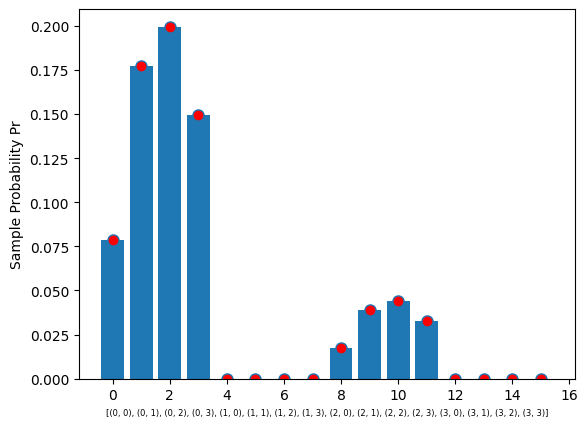

In [27]:
plt.bar(xaxis,Pn)
plt.plot(xaxis, Pth, marker='o', markersize=8, markerfacecolor='red', linestyle='none')
plt.xlabel(ln, fontsize=6);
plt.ylabel('Sample Probability Pr');
plt.savefig('BosonSamplingExample4b.pdf', format='pdf')

Comparison between the photon number evaluated with the model(bars) and the theory (red dots). Sampling patters are indicate in the labels.